# CESM2-LE Initial Condition Memory:  MOC(sigma2)
 - Retrieve annual MOC from POP monthly output for all members from 1850-2100
 - Plot decadal snapshots of Chi_ocn for LPF global MOC(sigma2)
 - Request at least 50GB on Casper login to run this notebook

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
from os.path import exists
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import calc
import intake
import pop_tools
from datetime import timedelta
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2022.12.1'

## Start Dask Cluster

In [3]:
# Close out Dask Cluster and release workers:
cluster.close()
client.close()

NameError: name 'cluster' is not defined

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='25GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        account='NCGD0011',
        walltime='02:00:00',
        local_directory='/glade/scratch/yeager/',
        log_directory='/glade/scratch/yeager/',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        "distributed.scheduler.worker-saturation": "1.0",
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yeager/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yeager/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.37:43020,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yeager/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Section 1: Data Ingest

### Retrieve pre-computed MOC(sigma2) for CESM2-LE

In [5]:
ledir = '/glade/work/yeager/cesm_output/CESM2_LE/MOCsig2/'
f1 = ledir+'CESM2LE.MOCsig2.1???-1???.cmip6.nc'
f2 = ledir+'CESM2LE.MOCsig2.2000-????.cmip6.nc'
f3 = ledir+'CESM2LE.MOCsig2.2010-????.cmip6.nc'
f4 = ledir+'CESM2LE.MOCsig2.20[1-9]5-????.cmip6.nc'
ds1 = xr.open_mfdataset(f1,combine='by_coords',
                       #preprocess=preprocessor,
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,chunks={'member_id':1})
ds2 = xr.open_mfdataset(f2,combine='by_coords',
                       #preprocess=preprocessor,
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,chunks={'member_id':1})
ds3 = xr.open_mfdataset(f3,combine='by_coords',
                       #preprocess=preprocessor,
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,chunks={'member_id':1})
ds4 = xr.open_mfdataset(f4,combine='by_coords',
                       #preprocess=preprocessor,
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,chunks={'member_id':1})
ds_cmip6 = xr.concat([ds1,ds2,ds3,ds4],dim='time')
cmip6_mocsig = ds_cmip6.MOC.sum('moc_comp').chunk({'time':251})

In [6]:
ledir = '/glade/work/yeager/cesm_output/CESM2_LE/MOCsig2/'
f1 = ledir+'CESM2LE.MOCsig2.1???-1???.smbb.nc'
f2 = ledir+'CESM2LE.MOCsig2.2000-????.smbb.nc'
f3 = ledir+'CESM2LE.MOCsig2.2010-????.smbb.nc'
f4 = ledir+'CESM2LE.MOCsig2.20[1-9]5-????.smbb.nc'
ds1 = xr.open_mfdataset(f1,combine='by_coords',
                       #preprocess=preprocessor,
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,chunks={'member_id':1})
ds2 = xr.open_mfdataset(f2,combine='by_coords',
                       #preprocess=preprocessor,
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,chunks={'member_id':1})
ds3 = xr.open_mfdataset(f3,combine='by_coords',
                       #preprocess=preprocessor,
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,chunks={'member_id':1})
#ds3 = ds3.assign_coords({'member_id':ds2.member_id})
ds4 = xr.open_mfdataset(f4,combine='by_coords',
                       #preprocess=preprocessor,
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,chunks={'member_id':1})
ds_smbb = xr.concat([ds1,ds2,ds3,ds4],dim='time')
smbb_mocsig = ds_smbb.MOC.sum('moc_comp').chunk({'time':251})

In [7]:
mocsig = xr.concat([cmip6_mocsig,smbb_mocsig],dim='member_id').astype('float32')
mocsig

<xarray.DataArray 'MOC' (member_id: 100, time: 251, transport_reg: 2,
                         sigma: 86, lat_aux_grid: 395)>
dask.array<concatenate, shape=(100, 251, 2, 86, 395), dtype=float32, chunksize=(1, 251, 2, 86, 395), chunktype=numpy.ndarray>
Coordinates:
  * lat_aux_grid   (lat_aux_grid) float64 -79.49 -78.95 -78.42 ... 89.47 90.0
  * member_id      (member_id) object 'r10i1181p1f1' ... 'r9i1171p1f2'
  * sigma          (sigma) float32 0.0 28.1 28.3 28.5 ... 37.88 37.93 37.97
  * transport_reg  (transport_reg) |S256 b'Global Ocean - Marginal Seas' b'At...
  * time           (time) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100

In [8]:
np.unique(mocsig.member_id.data).size

100

In [9]:
## Select region
mocreg = 0
mocsig = mocsig.isel(transport_reg=mocreg)

In [10]:
## Mask out streamfunction
mocsig_sd = mocsig.std('time')
mocsig = mocsig.where(mocsig_sd>0.1)

In [11]:
## Convert to dataset
memid = mocsig.member_id.data
inityear = xr.DataArray([i.split('i')[1].split('p')[0] for i in memid],coords={'member_id':mocsig.member_id})
memnum = xr.DataArray([i.split('i')[0].split('r')[1].rjust(3,'0') for i in memid],coords={'member_id':mocsig.member_id})

ds = mocsig.to_dataset()
ds['inityear'] = inityear
ds['memnum'] = memnum

In [12]:
ds

<xarray.Dataset>
Dimensions:        (lat_aux_grid: 395, member_id: 100, sigma: 86, time: 251)
Coordinates:
  * lat_aux_grid   (lat_aux_grid) float64 -79.49 -78.95 -78.42 ... 89.47 90.0
  * member_id      (member_id) object 'r10i1181p1f1' ... 'r9i1171p1f2'
  * sigma          (sigma) float32 0.0 28.1 28.3 28.5 ... 37.88 37.93 37.97
    transport_reg  |S256 b'Global Ocean - Marginal Seas'
  * time           (time) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
Data variables:
    MOC            (member_id, time, sigma, lat_aux_grid) float32 dask.array<chunksize=(1, 251, 86, 395), meta=np.ndarray>
    inityear       (member_id) <U4 '1181' '1231' '1251' ... '1131' '1151' '1171'
    memnum         (member_id) <U3 '010' '010' '010' '010' ... '007' '008' '009'

In [14]:
#%%time
#ds = ds.load()

In [15]:
#%%time
#from dask.distributed import wait
#ds = ds.persist()
#daskout = wait(ds)

# Section 2: ICM Analysis

In [13]:
# Print summary of initialization years in dataset
iyear = ds.inityear.data
print("Start Year : Members")
for i in set(iyear):
    count = np.count_nonzero(iyear==i)
    print(i+" : "+str(count).zfill(3))

Start Year : Members
1191 : 001
1091 : 001
1161 : 001
1111 : 001
1061 : 001
1301 : 020
1121 : 001
1001 : 001
1031 : 001
1281 : 020
1251 : 020
1081 : 001
1051 : 001
1231 : 020
1101 : 001
1181 : 001
1171 : 001
1141 : 001
1151 : 001
1041 : 001
1131 : 001
1011 : 001
1021 : 001
1071 : 001


## Remove PI-Control Drift

In [14]:
%%time
pidir = '/glade/work/yeager/cesm_output/CESM2_picntrl/'
f0 = pidir+'b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.0001-2000.MOCsig.nc'
ds0 = xr.open_dataset(f0)
#ds0 = xr.open_dataset(f0),chunks={'time':120}).persist()
#daskresult = wait(ds0)

CPU times: user 27.2 ms, sys: 10.1 ms, total: 37.4 ms
Wall time: 104 ms


In [15]:
pi_mocsig = ds0.MOC.sum('moc_comp').isel(transport_reg=mocreg)
pi_mocsig

<xarray.DataArray 'MOC' (time: 2000, sigma: 86, lat_aux_grid: 395)>
array([[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.6984050e-05,  5.9664635e-06,  1.7707007e-06],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.7085584e-05,  6.0680036e-06,  1.8722365e-06],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.6909571e-05,  5.8919854e-06,  1.6962188e-06],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -1.9922329e-08, -1.9922329e-08, -1.9922329e-08],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          8.2109040e-09,  8.2109040e-09,  8.2109040e-09],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          3.9451589e-09,  3.9451589e-09,  3.9451589e-09]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -9.3497918e-05, -2.7609201e-05, -8.3262023e-07],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -9.3579336e-05, -2.7690638e-05, -9.1405354e-07],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -9.3333976e-05, -2.7445240e-05, -6.6865664e-07],
...
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.8926011e-08,  1.8926011e-08,  1.8926011e-08],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.4908112e-08,  1.4908112e-08,  1.4908112e-08],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.1718722e-08,  1.1718722e-08,  1.1718722e-08]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          7.3613206e-05,  1.9240313e-05, -1.7333007e-06],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          7.3577859e-05,  1.9204972e-05, -1.7686423e-06],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          7.3438358e-05,  1.9065470e-05, -1.9081431e-06],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -2.0430551e-08, -2.0430551e-08, -2.0430551e-08],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -3.1813610e-08, -3.1813610e-08, -3.1813610e-08],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -6.0551049e-09, -6.0551049e-09, -6.0551049e-09]]], dtype=float32)
Coordinates:
  * lat_aux_grid   (lat_aux_grid) float64 -79.49 -78.95 -78.42 ... 89.47 90.0
  * sigma          (sigma) float32 0.0 28.1 28.3 28.5 ... 37.88 37.93 37.97
    transport_reg  |S256 b'Global Ocean - Marginal Seas'
  * time           (time) int64 1 2 3 4 5 6 7 ... 1995 1996 1997 1998 1999 2000

In [16]:
def fit_poly(dat, dim, degree):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    #dat = dat-fit
    return fit

In [17]:
pi_trend = fit_poly(pi_mocsig.sel(time=slice(800,1600)),'time',1)

#### Compute MOCsig anomalies as deviation from long term PI-Control trend (0800-1600)

In [18]:
%%time
# Loop over member_id, subtracting appropriate time slice of pi_trend from full MOCsig:
member_id = ds.member_id
memlist = []
for mem in member_id.values:
    ds_tmp = ds.sel(member_id=mem)
    y0 = int(ds_tmp.inityear.data.tolist())
    y1 = y0+250
    trend = pi_trend.sel(time=slice(y0,y1))
    trend['time'] = trend['time'] + (1850-y0)
    ds_tmp['MOC'] = ds_tmp['MOC'] - trend.astype('float32')
    memlist.append(ds_tmp)
ds_anom = xr.concat(memlist,dim=member_id)

CPU times: user 9.23 s, sys: 755 ms, total: 9.98 s
Wall time: 10.3 s


## Apply Low-Pass Filter

In [19]:
def lpf_anndata(dat, period=10, order=4):
    fs=1                      # 1/year
    nyquist = fs / 2          # 0.5 times the sampling frequency
    cutoff = 1/period        # cutoff frequency
    print('cutoff= ',period,' years') 
    filtsos = signal.butter(order, cutoff, 'lowpass', output='sos', fs=fs) #low pass filter
    b, a = signal.butter(order, cutoff, 'lowpass', output='ba', fs=fs) #low pass filter
    dat_out = xr.apply_ufunc(signal.sosfiltfilt, 
                             filtsos,dat.fillna(0),
                             dask='allowed',
                             kwargs={'padtype':'even','axis':0}).where(dat.notnull()).astype('float32')
    return dat_out,filtsos,a,b

In [20]:
%%time
moc_lpf,_,_,_ = lpf_anndata(ds.MOC.transpose('time','member_id','sigma','lat_aux_grid'),period=10,order=12)

cutoff=  10  years
CPU times: user 1min 12s, sys: 16.6 s, total: 1min 29s
Wall time: 1min 49s


In [21]:
%%time
moc_anom_lpf,_,_,_ = lpf_anndata(ds_anom.MOC.transpose('time','member_id','sigma','lat_aux_grid'),period=10,order=12)

cutoff=  10  years
CPU times: user 1min 15s, sys: 19.1 s, total: 1min 34s
Wall time: 2min


## Guide to Micro and Macro Ensembles:
  - 20-member micro ensembles referred to by start year: 1231, 1251, 1281, 1301
  - 10-member "macro1a" ensemble, initialized: 1001, 1021, 1041, 1061, 1081, 1101, 1121, 1141, 1161, 1181
  - 10-member "macro1b" (MOAR) ensemble, initialized: 1011, 1031, 1051, 1071, 1091, 1111, 1131, 1151, 1171, 1191
  - 10-member "macro2" ensemble (CMIP6 contribution):  b.e21.BHIST.f09_g17.CMIP6-historical.{001-010}


## Decomposition of Ensemble Variance:

Following Singh et al. (2021, in review), decompose CESM2LE ensemble variance for variable X as follows: 
$$ 
\sigma^{2}_{X} = \sigma^{2}_{X,ocn} + \sigma^{2}_{X,atm} 
$$ 
where "ocn" quantifies spread between micro ensembles (due to different ocean initial conditions), and "atm" quantifies spread within micro ensembles (due to perturbed atmospheric initial conditions). Variance within micro ensembles is computed as the average ensemble variance (with p=4, m=20):
$$ 
\sigma^{2}_{X,atm} = \frac{1}{p}\sum_{k=1}^{p}\frac{\sum_{j=1}^{m}(X_{k,j}-\overline{X_{k}})^2}{m}
$$ 
Variance across micro ensembles is computed as:
$$ 
\sigma^{2}_{X,ocn} = \frac{\sum_{k=1}^{p}(\overline{X_{k}}-\overline{X})^2}{p}
$$ 
where $\overline{X}$ is the mean over the full (80 member) ensemble. The fraction of ensemble variance attributable to ocean initial conditions is then:
$$ 
\chi_{ocn}(t) = \frac{\sigma^{2}_{X,ocn}(t)}{\sigma^{2}_{X}(t)}
$$ 

For denominator, keep only the 4 20-member micro ensemble members (80 members total):

In [23]:
%%time
iyear = ds.inityear.data
memind = np.nonzero((iyear=='1231') | (iyear=='1251') | (iyear=='1281') | (iyear=='1301'))
da_allmem = moc_lpf.isel(member_id=memind[0])
sig2_tot = da_allmem.var(dim='member_id')
allmean = da_allmem.mean(dim='member_id').load()

CPU times: user 34 s, sys: 9.77 s, total: 43.7 s
Wall time: 1min 21s


In [24]:
%%time
# Compute Ensemble Variance Decomposition:
plist = ['1231','1251','1281','1301']
varlist = []
meanlist = []
iyear = ds.inityear.data
for p in plist:
    memind = np.nonzero(iyear==p)
    da_oneinit = moc_anom_lpf.isel(member_id=memind[0])
    var = da_oneinit.var('member_id')
    mean = da_oneinit.mean('member_id')
    varlist.append(var)
    meanlist.append(mean)
sig2_atm = xr.concat(varlist,dim='p').mean('p')
sig2_ocn = xr.concat(meanlist,dim='p').var('p')
sig2_ocn_p = xr.concat(meanlist,dim=xr.DataArray(plist,dims='p',name='p'))
sig2_ocn_p = ((sig2_ocn_p - sig2_ocn_p.mean('p'))**2)/4

# Compute Chi
chi_atm = (sig2_atm/sig2_tot).rename("Chi_atm")
chi_ocn = (sig2_ocn/sig2_tot).rename("Chi_ocn")
chi_ocn_p = (sig2_ocn_p/sig2_tot).rename("Chi_ocn")

CPU times: user 86.1 ms, sys: 911 µs, total: 87 ms
Wall time: 89.4 ms


In [25]:
%%time
chi_atm = (dask.optimize(chi_atm)[0]).load()

CPU times: user 53.7 s, sys: 24.7 s, total: 1min 18s
Wall time: 2min 7s


In [26]:
%%time
chi_ocn = (dask.optimize(chi_ocn)[0]).load()

CPU times: user 55.5 s, sys: 19.9 s, total: 1min 15s
Wall time: 2min 22s


In [27]:
%%time
chi_ocn_p = (dask.optimize(chi_ocn_p)[0]).load()

CPU times: user 1min, sys: 28.4 s, total: 1min 28s
Wall time: 2min 28s


## Compute bootstrapped significance

In [46]:
import xskillscore as xs

Resample 80-member pool (with replacement), to generate 100 different synthetic 20-member "micro" ensembles:

In [57]:
%%time
iterations = 100
ens_size = 20
da_allmem = moc_anom_lpf.isel(member_id=memind[0])
da_allmem_r = xs.resample_iterations(da_allmem, iterations, 'member_id', dim_max=ens_size).rename({'iteration':'micro'})

CPU times: user 414 ms, sys: 7.96 ms, total: 422 ms
Wall time: 440 ms


Now, resample again to generate 100 different 4-micro combinations:

In [86]:
da_allmem_rr = xs.resample_iterations(da_allmem_r, 100, 'micro', dim_max=4)

Compute resampled distributions of sig2_atm, sig2_ocn, and chi_ocn:

In [87]:
%%time
sig2_atm_r = da_allmem_rr.var(dim='member_id').mean('micro')
sig2_ocn_r = da_allmem_rr.mean(dim='member_id').var('micro')
sig2_tot_r = da_allmem_rr.var(dim=['member_id','micro'])
chi_atm_r = (sig2_atm_r/sig2_tot_r).rename("Chi_atm_r")
chi_ocn_r = (sig2_ocn_r/sig2_tot_r).rename("Chi_ocn_r")

CPU times: user 161 ms, sys: 1.92 ms, total: 162 ms
Wall time: 165 ms


In [88]:
(chi_ocn_r['iteration'].size)

100

In [89]:
%%time
pval_chi_ocn = ((chi_ocn_r > chi_ocn).sum('iteration')/chi_ocn_r['iteration'].size).astype('float32')

CPU times: user 78 ms, sys: 0 ns, total: 78 ms
Wall time: 78 ms


In [90]:
pval_chi_ocn

<xarray.DataArray (time: 251, sigma: 86, lat_aux_grid: 395)>
dask.array<astype, shape=(251, 86, 395), dtype=float32, chunksize=(251, 86, 395), chunktype=numpy.ndarray>
Coordinates:
  * lat_aux_grid   (lat_aux_grid) float64 -79.49 -78.95 -78.42 ... 89.47 90.0
  * sigma          (sigma) float32 0.0 28.1 28.3 28.5 ... 37.88 37.93 37.97
    transport_reg  |S256 b'Global Ocean - Marginal Seas'
  * time           (time) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100

In [91]:
%%time
pval_chi_ocn = (dask.optimize(pval_chi_ocn)[0]).load()

Task exception was never retrieved
future: <Task finished name='Task-1301346' coro=<Client._gather.<locals>.wait() done, defined at /glade/work/yeager/conda-envs/cesm2-LE/lib/python3.8/site-packages/distributed/client.py:2122> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/work/yeager/conda-envs/cesm2-LE/lib/python3.8/site-packages/distributed/client.py", line 2131, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

### Plot Chi for MOCsig as a function of historical time

In [38]:
np.arange(1855,2105,10)

array([1855, 1865, 1875, 1885, 1895, 1905, 1915, 1925, 1935, 1945, 1955,
       1965, 1975, 1985, 1995, 2005, 2015, 2025, 2035, 2045, 2055, 2065,
       2075, 2085, 2095])

CPU times: user 5.9 s, sys: 134 ms, total: 6.03 s
Wall time: 6.19 s


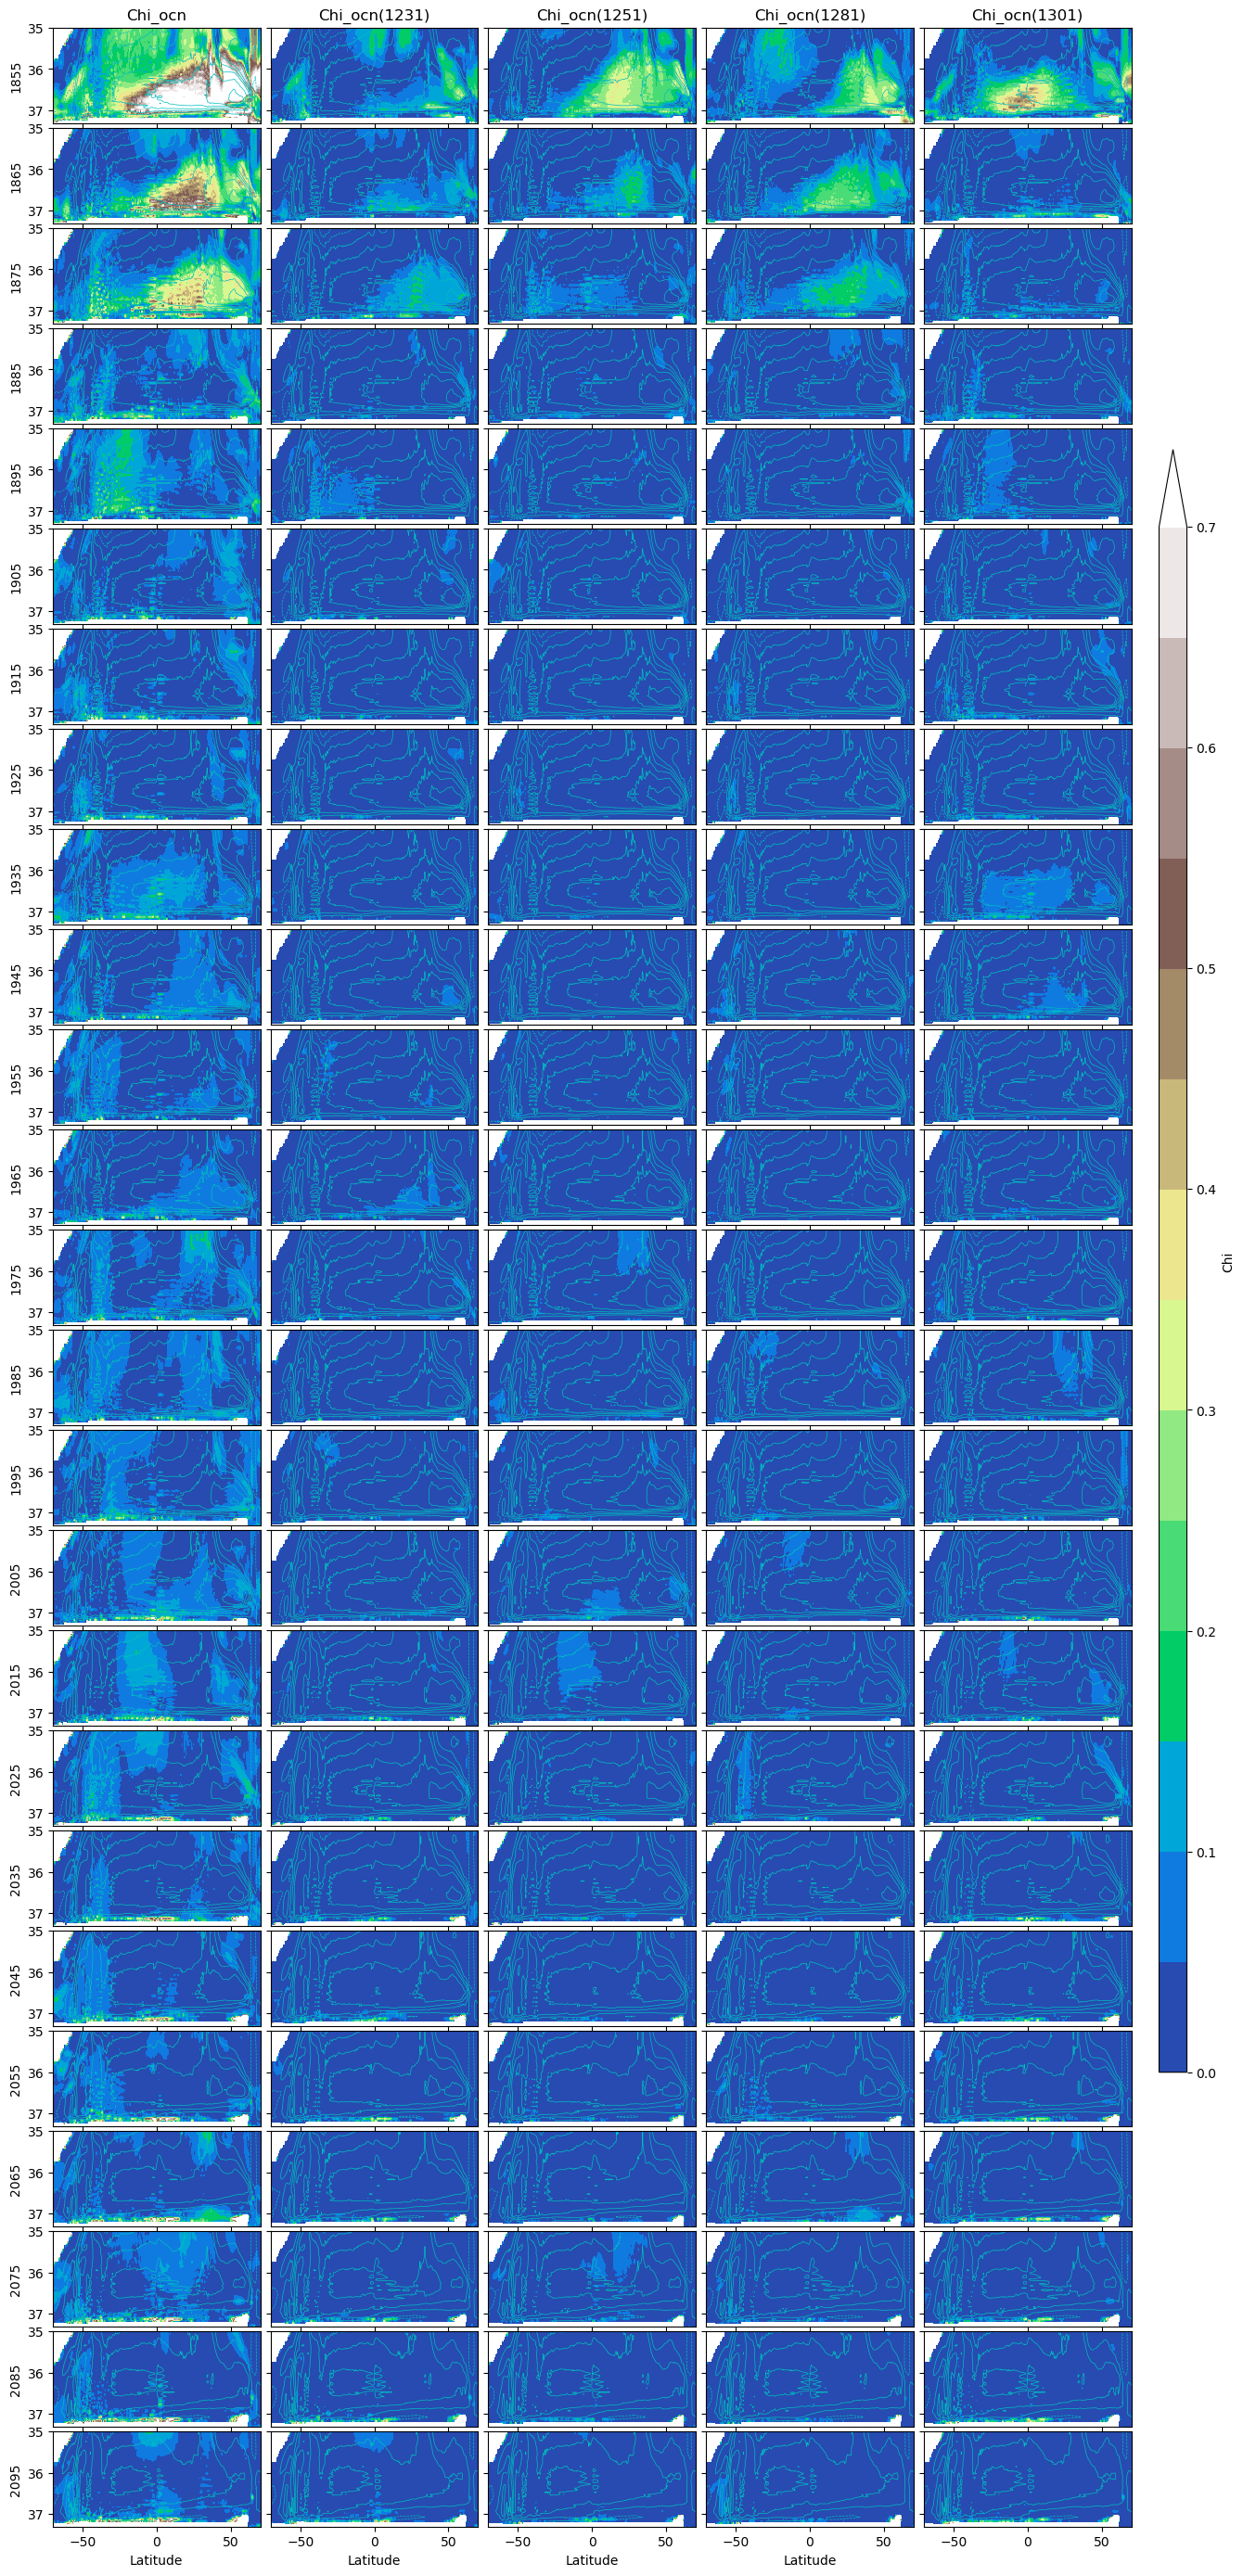

In [40]:
%%time
time0 = np.arange(1855,2105,10)
nrow = np.shape(time0)[0]
ncol = 5
fig = plt.figure(figsize=(15, 35))

#mnlevs = np.arange(0,31,1)*2. - 30.
mnlevs = np.arange(0,16,1)*4. - 30.
chilevs = np.arange(0,15,1)*0.05
yticks = [29,30,31,32,33,34,35,36,37,38]
colmap = copy.copy(plt.cm.terrain)
fontsize=12
mnclr = 'c'

xlim=[-70,70]
ylim=[37.3,35.]
imax = np.array(range(nrow)).max()

for i in range(nrow):
    y0 = time0[i]
    timestamp = str(y0)
    mean = allmean.sel(time=y0)
    chi_o = chi_ocn.sel(time=y0)
    chi_o_p = chi_ocn_p.sel(time=y0)
    
    ax1 = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr1 = ax1.contour(mean.lat_aux_grid, mean.sigma, mean,levels=mnlevs, linewidths=0.5, colors=mnclr)
    cntr1a = ax1.contourf(chi_o.lat_aux_grid, chi_o.sigma, chi_o,levels=chilevs, cmap=colmap, extend='max')
    cntr1a.cmap.set_over('w')
    ax1.set_ylim(ylim)
    ax1.set_xlim(xlim)
    ax1.set_ylabel(timestamp)
    if i!=imax: ax1.set_xticklabels([])
    if i==0: ax1.set_title('Chi_ocn', fontdict={'size':fontsize}, loc='center')
        
    ax2 = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr2 = ax2.contour(mean.lat_aux_grid, mean.sigma, mean,levels=mnlevs, linewidths=0.5, colors=mnclr)
    cntr2a = ax2.contourf(chi_o_p.lat_aux_grid, chi_o_p.sigma, chi_o_p.sel(p='1231'),levels=chilevs, cmap=colmap, extend='max')
    cntr2a.cmap.set_over('w')
    ax2.set_ylim(ylim)
    ax2.set_xlim(xlim)
    if i!=imax: ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    if i==0: ax2.set_title('Chi_ocn(1231)', fontdict={'size':fontsize}, loc='center')
        
    ax3 = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr3 = ax3.contour(mean.lat_aux_grid, mean.sigma, mean,levels=mnlevs, linewidths=0.5, colors=mnclr)
    cntr3a = ax3.contourf(chi_o_p.lat_aux_grid, chi_o_p.sigma, chi_o_p.sel(p='1251'),levels=chilevs, cmap=colmap, extend='max')
    cntr3a.cmap.set_over('w')
    ax3.set_ylim(ylim)
    ax3.set_xlim(xlim)
    if i!=imax: ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    if i==0: ax3.set_title('Chi_ocn(1251)', fontdict={'size':fontsize}, loc='center')
    
    ax4 = fig.add_subplot(nrow,ncol,i*ncol+4)
    cntr4 = ax4.contour(mean.lat_aux_grid, mean.sigma, mean,levels=mnlevs, linewidths=0.5, colors=mnclr)
    cntr4a = ax4.contourf(chi_o_p.lat_aux_grid, chi_o_p.sigma, chi_o_p.sel(p='1281'),levels=chilevs, cmap=colmap, extend='max')
    cntr4a.cmap.set_over('w')
    ax4.set_ylim(ylim)
    ax4.set_xlim(xlim)
    if i!=imax: ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    if i==0: ax4.set_title('Chi_ocn(1281)', fontdict={'size':fontsize}, loc='center')
    
    ax5 = fig.add_subplot(nrow,ncol,i*ncol+5)
    cntr5 = ax5.contour(mean.lat_aux_grid, mean.sigma, mean,levels=mnlevs, linewidths=0.5, colors=mnclr)
    cntr5a = ax5.contourf(chi_o_p.lat_aux_grid, chi_o_p.sigma, chi_o_p.sel(p='1301'),levels=chilevs, cmap=colmap, extend='max')
    cntr5a.cmap.set_over('w')
    ax5.set_ylim(ylim)
    ax5.set_xlim(xlim)
    if i!=imax: ax5.set_xticklabels([])
    ax5.set_yticklabels([])
    if i==0: ax5.set_title('Chi_ocn(1301)', fontdict={'size':fontsize}, loc='center')
        
    if (i==np.array(range(nrow)).max()):
        ax1.set_xlabel('Latitude')
        ax2.set_xlabel('Latitude')
        ax3.set_xlabel('Latitude')
        ax4.set_xlabel('Latitude')

fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1a, cax=cbar_ax, label='Chi')